# Convolutional Autoencoder



## IMPORT

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import random
import cv2
from collections import Counter  # Import Counter at the top
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


## LOAD DATA

In [6]:
# Path to the extracted dataset
extracted_path = 'Desktop/CV/milestone_2'

# Maximum number of classes to use
max_classes = 100

# Function to load images and labels
def load_casia_webface_data(dataset_path, max_classes=max_classes):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    # Walk through dataset directories
    for subdir, dirs, _ in os.walk(dataset_path):
        for dir_name in sorted(dirs):  # Sorting for consistency
            if current_label >= max_classes:
                break  # Stop after reaching max_classes

            identity_dir = os.path.join(subdir, dir_name)
            label_map[current_label] = dir_name  # Map label to identity
            # print(f"Processing identity: {dir_name} (Label {current_label})")

            # Process all images in the identity's folder
            for img_file in os.listdir(identity_dir):
                img_path = os.path.join(identity_dir, img_file)

                # Skip non-image files
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Load and preprocess the image
                img = cv2.imread(img_path)
                if img is None:
                    # print(f"Warning: Unable to read image {img_path}")
                    continue

                img = cv2.resize(img, (64, 64))  # Resize to 64x64 (or the desired size)
                images.append(img)
                labels.append(current_label)

            current_label += 1

        if current_label >= max_classes:
            break

    if not images:
        raise ValueError("No images were loaded. Please check the dataset structure and image paths.")

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return images, labels, label_map

# Load dataset
try:
    images, labels, label_map = load_casia_webface_data(extracted_path, max_classes=max_classes)
    print(f"Loaded {images.shape[0]} images with {len(label_map)} identities.")
except ValueError as e:
    print(f"Error: {e}")


Loaded 14650 images with 100 identities.


## Normalize the features by subtracting the mean and dividing by the standard deviation for each channel


In [8]:
mean = np.mean(images, axis=(0, 1, 2), keepdims=True)
std = np.std(images, axis=(0, 1, 2), keepdims=True)

normalized_features = (images - mean) / std

## Display images with a global title and normalization 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


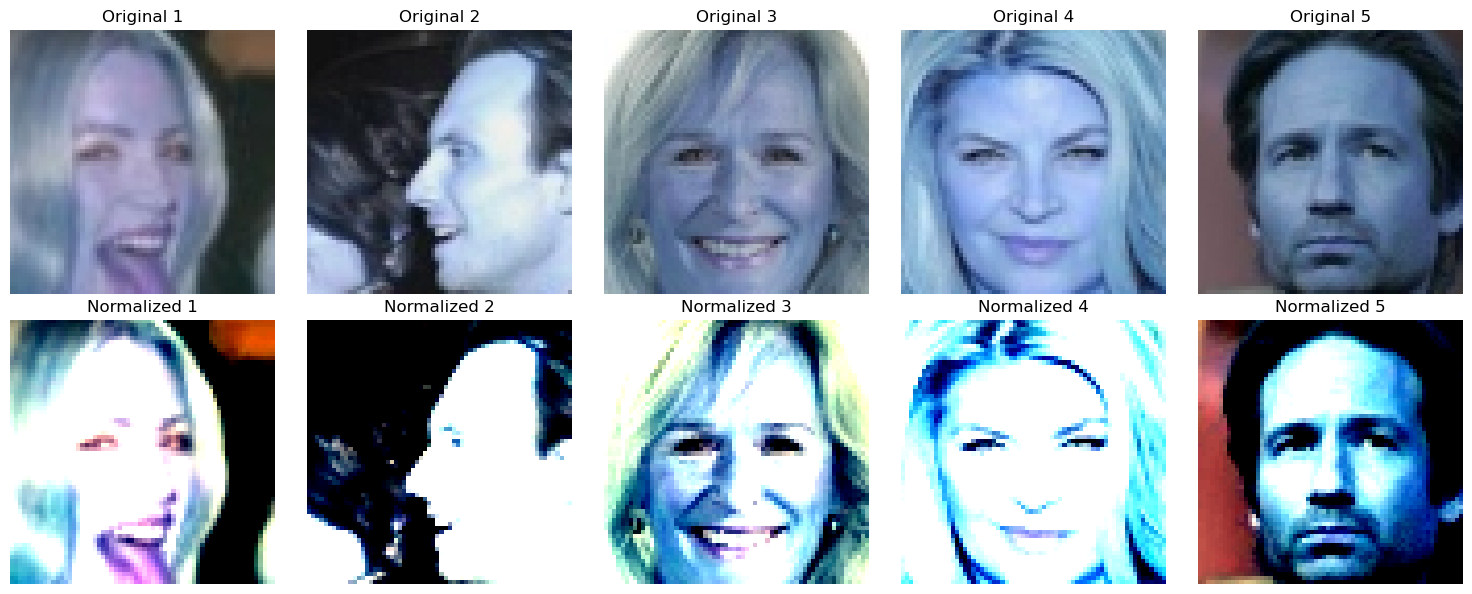

In [9]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = random.sample(range(0, len(images)), num_samples)

# Create a figure for displaying images (2 rows: 1 for original, 1 for normalized)
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

# Loop through each random index and display the corresponding images
for i, idx in enumerate(random_indices):
    # Get the original image
    original_image = images[idx].astype("uint8")
    
    # Get the normalized image
    normalized_image = normalized_features[idx].astype("float32")

    # Display the original image
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Display the normalized image
    axes[1, i].imshow(normalized_image)
    axes[1, i].set_title(f"Normalized {i+1}")
    axes[1, i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## SPLIT DATA

In [11]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

## Check the shapes of the splits

In [13]:
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")

Training set size: (10255, 64, 64, 3), (10255,)
Validation set size: (2197, 64, 64, 3), (2197,)
Test set size: (2198, 64, 64, 3), (2198,)


## ENCODER DECODER(before CV)

In [15]:

encoding_dim = 128  # Latent space dimension (increase size for better performance)

# Build the autoencoder model
input_img = tf.keras.Input(shape=(64, 64, 3))

# Encoder: Multiple Conv2D and MaxPooling2D layers to progressively compress the image
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = tf.keras.layers.BatchNormalization()(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder: UpSampling2D and Conv2D layers to reconstruct the image
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)

decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the model that takes an image and outputs the reconstructed image
autoencoder = tf.keras.Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Display the summary of the model to verify the architecture
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963 (19.39 KB)

 Trainable params: 4,963 (19.39 KB)

 Non-trainable params: 0 (0.00 B)

## Cross validation 

In [13]:
# Function to build the autoencoder model with parameterized layers and neurons
def build_autoencoder(conv_layers_config):
    input_img = tf.keras.Input(shape=(64, 64, 3))
    x = input_img

    # Encoder: Create Conv2D and MaxPooling2D layers based on the configuration
    for filters in conv_layers_config['encoder']:
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder: Create UpSampling2D and Conv2D layers (reverse of encoder)
    for filters in conv_layers_config['decoder']:
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Define the model
    autoencoder = tf.keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return autoencoder

# Example dataset (replace this with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameter search space (number of filters per Conv2D layer in encoder/decoder)
layer_neuron_combinations = [
    {'encoder': [256, 128], 'decoder': [128, 256]},  # Reduced complexity
    {'encoder': [1024, 512], 'decoder': [512, 1024]},  # Another balanced configuration
]

# Cross-validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduced to 3 splits for faster testing
results = {}

# Sampling size: 1-5% of the training set in each fold for faster experimentation
sample_fraction = 0.05

# Function to train and evaluate the model for each configuration
def train_and_evaluate(config, X_train, X_val):
    fold_losses = []
    
    # Take a random sample of the training data (5% for quicker testing)
    train_sample_size = int(len(X_train) * sample_fraction)
    sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
    X_train_sampled = X_train[sampled_indices]
    
    # Build the autoencoder model for the current configuration
    autoencoder = build_autoencoder(config)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = autoencoder.fit(
        X_train_sampled, X_train_sampled,  # Input is the target (autoencoder)
        validation_data=(X_val, X_val),
        epochs=5,  # Reduced epochs for quicker testing
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Record validation loss for the fold
    val_loss = history.history['val_loss'][-1]
    fold_losses.append(val_loss)
    
    return np.mean(fold_losses)

# Parallelize K-Fold Cross-Validation using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    for config in layer_neuron_combinations:
        print(f"Testing configuration: {config}")
        fold_losses = []

        # Perform K-Fold Cross-Validation
        futures = []
        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            # Submit the train-and-evaluate task to the thread pool
            futures.append(executor.submit(train_and_evaluate, config, X_train, X_val))

        # Collect results from all futures (fold losses)
        for future in futures:
            fold_losses.append(future.result())
        
        # Compute the average validation loss for the configuration
        avg_val_loss = np.mean(fold_losses)
        results[str(config)] = avg_val_loss
        print(f"Average Validation Loss for {config}: {avg_val_loss}")

# Find the best configuration (the one with the lowest average validation loss)
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing configuration: {'encoder': [256, 128], 'decoder': [128, 256]}
Average Validation Loss for {'encoder': [256, 128], 'decoder': [128, 256]}: 0.08172966291507085
Testing configuration: {'encoder': [1024, 512], 'decoder': [512, 1024]}
Average Validation Loss for {'encoder': [1024, 512], 'decoder': [512, 1024]}: 0.08321293691794078
Best Configuration: {'encoder': [256, 128], 'decoder': [128, 256]} with Loss: 0.08172966291507085


## New cross validation 

In [ ]:
# Function to build the autoencoder model with parameterized layers and neurons
def build_autoencoder(conv_layers_config):
    input_img = tf.keras.Input(shape=(64, 64, 3))
    x = input_img

    # Encoder: Create Conv2D and MaxPooling2D layers based on the configuration
    for filters in conv_layers_config['encoder']:
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder: Create UpSampling2D and Conv2D layers (reverse of encoder)
    for filters in conv_layers_config['decoder']:
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Define the model
    autoencoder = tf.keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return autoencoder

# Example dataset (replace this with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameter search space (number of filters per Conv2D layer in encoder/decoder)
# Hyperparameter search space with more layers for both encoder and decoder
layer_neuron_combinations = [
    {'encoder': [512, 256, 128], 'decoder': [128, 256, 512]},  # Deeper configuration with 3 layers
    {'encoder': [1024, 512, 256], 'decoder': [256, 512, 1024]},  # Another deeper configuration
    {'encoder': [2048, 1024, 512], 'decoder': [512, 1024, 2048]},  # Deepest configuration with more filters
]


# Cross-validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduced to 3 splits for faster testing
results = {}

# Sampling size: 1-5% of the training set in each fold for faster experimentation
sample_fraction = 0.05

# Function to train and evaluate the model for each configuration
def train_and_evaluate(config, X_train, X_val):
    fold_losses = []
    
    # Take a random sample of the training data (5% for quicker testing)
    train_sample_size = int(len(X_train) * sample_fraction)
    sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
    X_train_sampled = X_train[sampled_indices]
    
    # Build the autoencoder model for the current configuration
    autoencoder = build_autoencoder(config)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = autoencoder.fit(
        X_train_sampled, X_train_sampled,  # Input is the target (autoencoder)
        validation_data=(X_val, X_val),
        epochs=5,  # Reduced epochs for quicker testing
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Record validation loss for the fold
    val_loss = history.history['val_loss'][-1]
    fold_losses.append(val_loss)
    
    return np.mean(fold_losses)

# Parallelize K-Fold Cross-Validation using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    for config in layer_neuron_combinations:
        print(f"Testing configuration: {config}")
        fold_losses = []

        # Perform K-Fold Cross-Validation
        futures = []
        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            # Submit the train-and-evaluate task to the thread pool
            futures.append(executor.submit(train_and_evaluate, config, X_train, X_val))

        # Collect results from all futures (fold losses)
        for future in futures:
            fold_losses.append(future.result())
        
        # Compute the average validation loss for the configuration
        avg_val_loss = np.mean(fold_losses)
        results[str(config)] = avg_val_loss
        print(f"Average Validation Loss for {config}: {avg_val_loss}")

# Find the best configuration (the one with the lowest average validation loss)
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing configuration: {'encoder': [512, 256, 128], 'decoder': [128, 256, 512]}
Average Validation Loss for {'encoder': [512, 256, 128], 'decoder': [128, 256, 512]}: 0.08333429197470348
Testing configuration: {'encoder': [1024, 512, 256], 'decoder': [256, 512, 1024]}
Average Validation Loss for {'encoder': [1024, 512, 256], 'decoder': [256, 512, 1024]}: 0.08333318680524826
Testing configuration: {'encoder': [2048, 1024, 512], 'decoder': [512, 1024, 2048]}


## Split the data into train and test sets

In [55]:
# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

## ENCODER DECODER(after CV)

In [58]:
# Input
input_img = tf.keras.Input(shape=(64, 64, 3))

# Encoder
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)  # 256 filters
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)  # 64x64 -> 32x32
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # 128 filters
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32 -> 16x16
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16 -> 8x8

# Decoder
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)  # 128 filters
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # 8x8 -> 16x16
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # 256 filters
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # 16x16 -> 32x32
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # 32x32 -> 64x64
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer

# Define the autoencoder model
autoencoder = tf.keras.Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Display the summary of the model
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 3)      │         6,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,875 (2.87 MB)

 Trainable params: 751,875 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

## Train the autoencoder with reshaped images

In [61]:
# Reshape the data to match input shape for training
X_train_reshaped = X_train.reshape(-1, 64, 64, 3)
X_val_reshaped = X_val.reshape(-1, 64, 64, 3)
X_test_reshaped = X_test.reshape(-1, 64, 64, 3)

# Train the autoencoder with reshaped images
history = autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=32, shuffle=True, validation_data=(X_val_reshaped, X_val_reshaped))

# After training, extract the encoder part of the autoencoder to get the encoded features
encoder = tf.keras.Model(input_img, encoded)
#encoder.save("encoder.h5")

Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 103s 316ms/step - accuracy: 0.7772 - loss: 0.4368 - val_accuracy: 0.8501 - val_loss: 0.3591
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 104s 323ms/step - accuracy: 0.8637 - loss: 0.3552 - val_accuracy: 0.8746 - val_loss: 0.3531
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 99s 308ms/step - accuracy: 0.8739 - loss: 0.3516 - val_accuracy: 0.8790 - val_loss: 0.3499
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 96s 300ms/step - accuracy: 0.8798 - loss: 0.3437 - val_accuracy: 0.8635 - val_loss: 0.3489
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 97s 301ms/step - accuracy: 0.8801 - loss: 0.3462 - val_accuracy: 0.8824 - val_loss: 0.3473
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 97s 301ms/step - accuracy: 0.8795 - loss: 0.3444 - val_accuracy: 0.8795 - val_loss: 0.3465
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 97s 301ms/step - accuracy: 0.8790 - loss: 0.3439 - val_accuracy: 0.8726 - val_loss: 0.3459
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 96s 301ms/step - accuracy: 0.8772 - loss:

## Extract the encoded features

In [63]:
#encoder = load_model("encoder.h5")
# Extract the encoded features for the training, validation, and test sets
encoded_features_train = encoder.predict(X_train_reshaped)
encoded_features_val = encoder.predict(X_val_reshaped)
encoded_features_test = encoder.predict(X_test_reshaped)

encoded_features_train = encoded_features_train.reshape(encoded_features_train.shape[0], -1)
encoded_features_val = encoded_features_val.reshape(encoded_features_val.shape[0], -1)
encoded_features_test = encoded_features_test.reshape(encoded_features_test.shape[0], -1)

321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


## Display the Original and Reconstructed images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


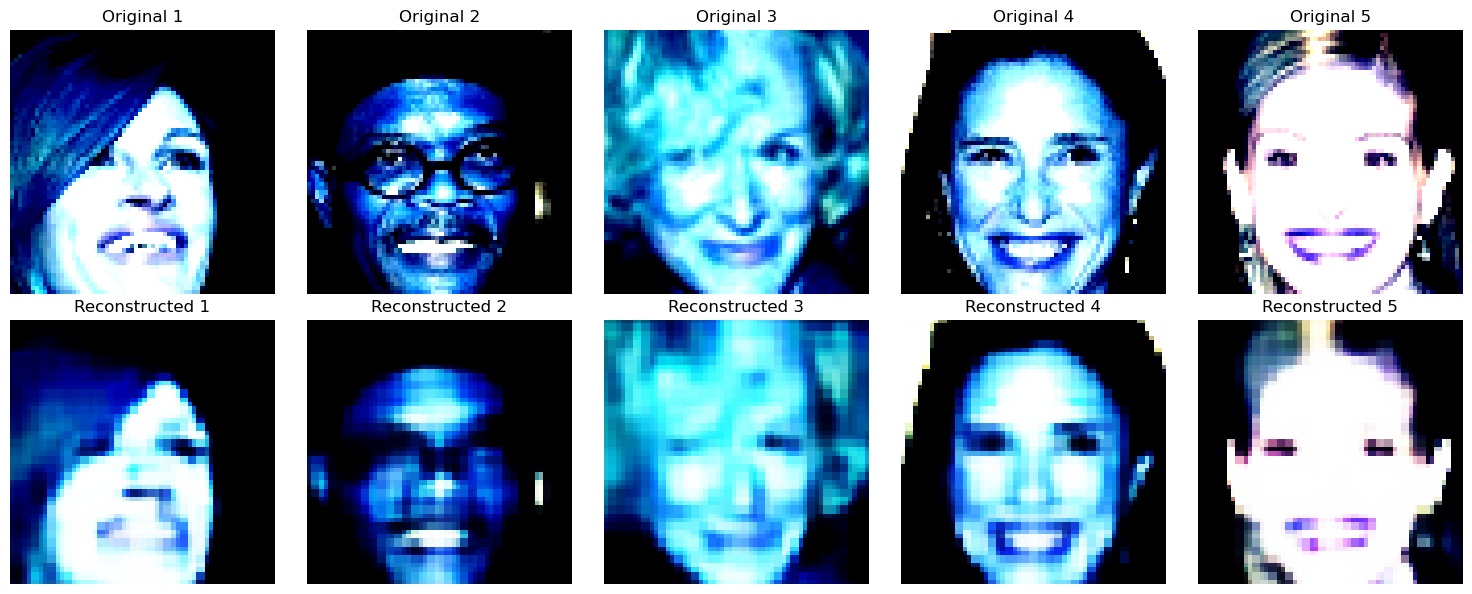

In [65]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, X_train_reshaped.shape[0], num_samples)

# Create a figure for displaying images (2 rows: 1 for original, 1 for reconstructed)
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Loop through each random index and display the corresponding images
for i, idx in enumerate(random_indices):
    # Get the original image
    original_image = X_train_reshaped[idx]

    # Reconstruct the image using the autoencoder
    reconstructed_image = autoencoder.predict(np.expand_dims(original_image, axis=0))

    # Visualize the original image
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Visualize the reconstructed image
    axes[1, i].imshow(reconstructed_image[0])  # Reconstructed image is in the range [0, 1], take the first image from the batch
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [69]:
encoded_features_train.shape

(10255, 8192)

In [71]:
y_train.shape

(10255,)

## VIsualization

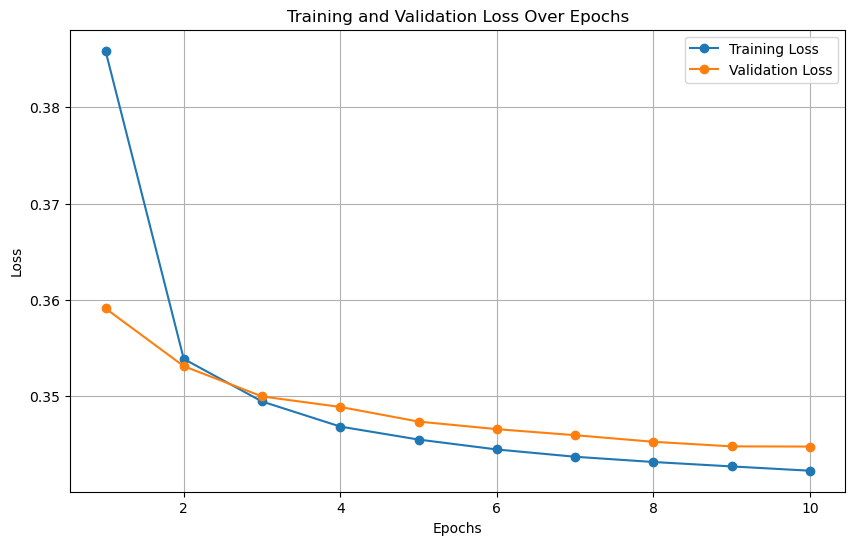

In [74]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Own implementation of the KNN algorithm

In [77]:
def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

class the_minimum_Euclidean_distance_classifier:
    def __init__(self, k=3): #we make default 3 the votes might be 2:1, ensuring a clear winner smaller than will be no winner or overfitting
        self.k = k

    def fit(self, X, y): #fit means stores our trainnig set
        self.X_train = X    
        self.y_train = y

    def _predict(self, x):
        # compute the distance
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train] #x is the test set from xtrain to last value in x_train 
    
        # get the closest k
        k_indices_feature = np.argsort(distances)[:self.k] ## sorting ascending order to find the nearest point and determine which class belongs
        k_nearest_labels = [self.y_train[i] for i in k_indices_feature]

        # majority voye
        most_common = Counter(k_nearest_labels).most_common()  ## to count the occurrences of each element in an iterable (like a list).
        return most_common[0][0]  ##first element in first label
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

## KNN classifier built with a manually implemented KNN algorithm

In [80]:
classifier = the_minimum_Euclidean_distance_classifier(k=1)
classifier.fit(encoded_features_train, y_train)
y_pred = classifier.predict(encoded_features_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")  

Recognition Accuracy: 33.94%


## KNN classifier using the scikit-learn library

In [82]:
# Train the classifier on the encoded features of the training set
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(encoded_features_test)

# Evaluate the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")

Recognition Accuracy: 33.94%


## Display a random image from the test set along with its true and predicted labels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


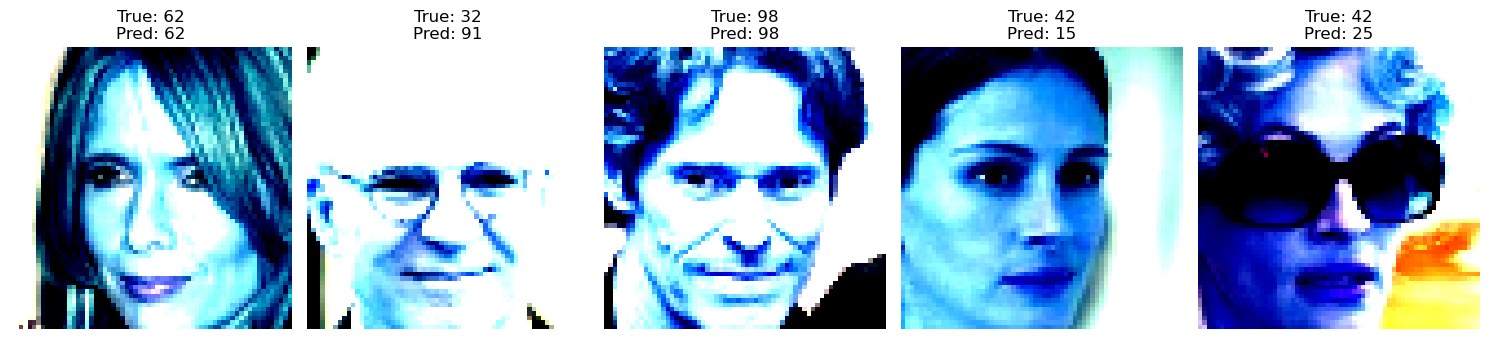

In [85]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = random.sample(range(0, len(X_test_reshaped)), num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# Loop through each random index and display the corresponding image
for i, idx in enumerate(random_indices):
    # Get the image, true label, and predicted label
    random_image = X_test_reshaped[idx]
    true_label = y_test[idx]
    predicted_label = y_pred[idx]

    # Display the image
    axes[i].imshow(random_image)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()